# LSTM

- reference: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook

## Omajinai

In [1]:
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM #, GRU, Bidirectional
import tensorflow as tf

## Data

In [3]:
!wget https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv -O newly_confirmed_cases_daily.csv

--2022-08-10 19:26:13--  https://covid19.mhlw.go.jp/public/opendata/newly_confirmed_cases_daily.csv
Resolving covid19.mhlw.go.jp (covid19.mhlw.go.jp)... 13.33.174.14, 13.33.174.106, 13.33.174.89, ...
Connecting to covid19.mhlw.go.jp (covid19.mhlw.go.jp)|13.33.174.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141612 (138K) [application/octet-stream]
Saving to: ‘newly_confirmed_cases_daily.csv’

newly_confirmed_cas 100%[===================>] 138.29K  --.-KB/s    in 0.04s   

2022-08-10 19:26:13 (3.18 MB/s) - ‘newly_confirmed_cases_daily.csv’ saved [141612/141612]



In [4]:
df = pd.read_csv('newly_confirmed_cases_daily.csv', index_col=0)
df.index = pd.to_datetime(df.index)
print(df.shape)
display(df.head(1))
display(df.tail(5))

(937, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-05,233730,7210,1494,1034,3093,985,939,1756,4833,2332,...,1574,1131,12250,1630,2359,4065,1982,2158,3334,5720
2022-08-06,227536,6881,1542,1132,3035,1020,1050,1828,4708,2611,...,2155,1192,12649,1499,2377,3817,1967,2355,3356,5066
2022-08-07,206463,6322,1248,969,2448,829,938,2066,4377,2102,...,1675,1142,10767,1102,2560,4001,1841,2431,3123,4277
2022-08-08,137826,5098,1083,803,1500,404,676,1105,2887,1076,...,829,439,8461,1339,1915,1339,1025,1665,2145,2608
2022-08-09,212531,5546,1035,794,3585,1332,1064,1699,2741,3279,...,2841,1170,10665,2037,2546,4448,2322,2406,3868,4289


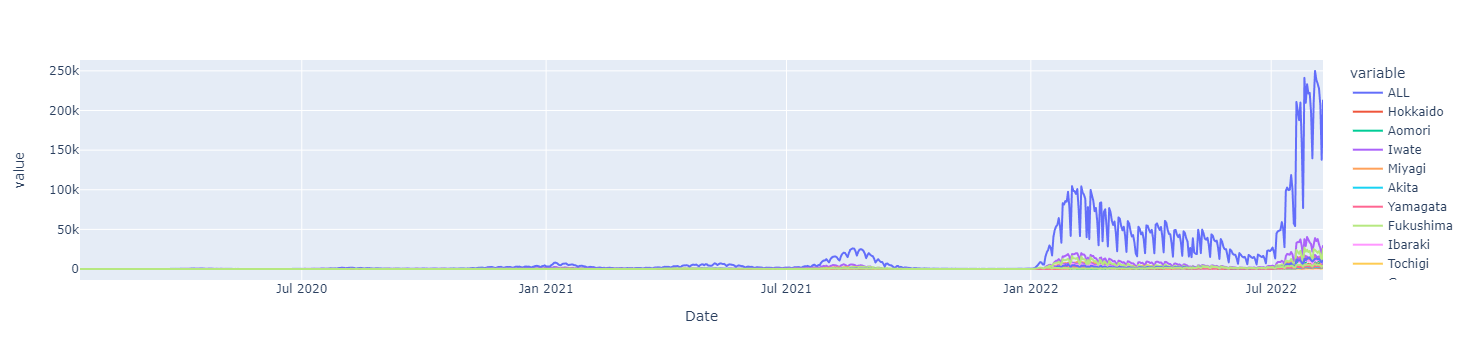

In [5]:
px.line(df, )

In [6]:
df_gr = df.groupby(pd.Grouper(level='Date', freq='W')).mean()
df_gr = df_gr.drop(df_gr.index[-1])
last_date = df_gr.index[-1]
print(df_gr.shape)
display(df_gr.head(1))
display(df_gr.tail(5))

(134, 48)


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-19,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ALL,Hokkaido,Aomori,Iwate,Miyagi,Akita,Yamagata,Fukushima,Ibaraki,Tochigi,...,Ehime,Kochi,Fukuoka,Saga,Nagasaki,Kumamoto,Oita,Miyazaki,Kagoshima,Okinawa
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-10,44807.428571,766.571429,457.857143,203.000000,396.285714,91.857143,93.142857,212.571429,477.428571,269.000000,...,479.857143,180.142857,2474.428571,573.285714,482.142857,1073.428571,519.142857,508.714286,734.857143,2136.000000
2022-07-17,92526.142857,1452.857143,836.857143,496.714286,751.142857,276.142857,183.571429,466.428571,1129.857143,699.857143,...,723.142857,307.142857,5303.571429,857.714286,743.857143,1637.285714,957.714286,910.857143,1442.571429,3304.000000
2022-07-24,153853.142857,3208.000000,1137.142857,787.000000,1830.000000,591.142857,344.000000,955.857143,2347.142857,1568.571429,...,983.571429,509.000000,8255.285714,1002.857143,1126.714286,2231.000000,1366.857143,1537.142857,2167.285714,4194.142857
2022-07-31,200314.142857,5414.571429,1357.571429,964.571429,2775.571429,926.857143,703.142857,1405.714286,3048.428571,2317.571429,...,1304.857143,746.857143,11353.285714,1362.714286,1897.142857,3441.571429,1565.857143,2027.857143,2937.428571,4850.571429
2022-08-07,215278.857143,6251.857143,1361.857143,993.000000,2799.714286,933.571429,949.714286,1705.142857,4113.428571,2538.428571,...,1710.000000,1004.285714,11749.571429,1525.714286,2282.428571,3788.428571,1907.428571,2276.000000,3221.285714,5020.857143


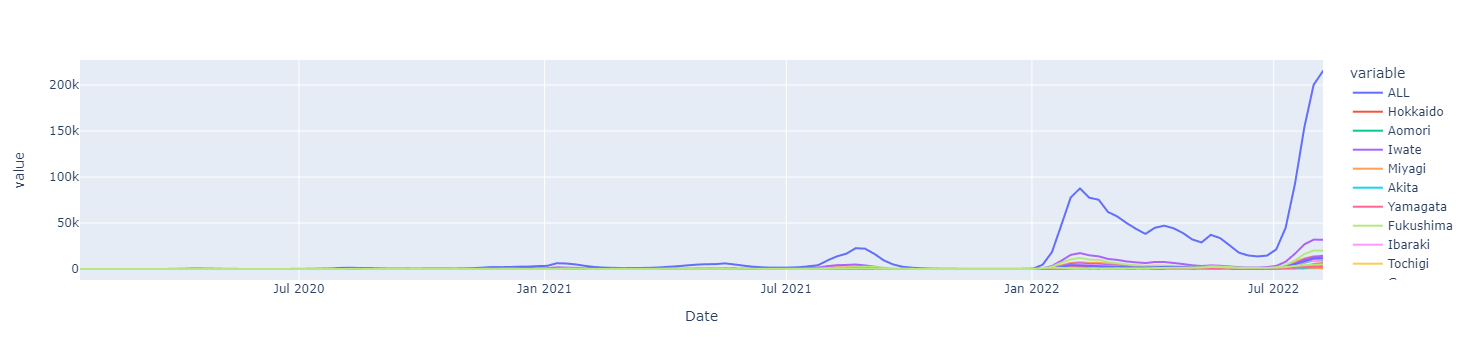

In [7]:
px.line(df_gr,)

### Scale

In [8]:
sc = MinMaxScaler(feature_range=(0,1))
ts_all = df_gr.ALL
ts_all_sc = sc.fit_transform(ts_all.values.reshape(-1, 1)).ravel()
ts_all_sc = pd.Series(ts_all_sc, index=ts_all.index)
ts_all_sc.head(1)

Date
2020-01-19    0.0
Freq: W-SUN, dtype: float64

### FE

In [9]:
forecast_weeks = 12
# df_fe = df_gr.ALL.to_frame()
df_fe = ts_all_sc.to_frame(name='ALL')

# add new rows for forecast
index_list = pd.date_range(ts_all_sc.index[-1]+relativedelta(weeks=1), ts_all_sc.index[-1]+relativedelta(weeks=forecast_weeks), freq='W')
df_fe = pd.concat([df_fe, pd.DataFrame(index=index_list)])

# shift
for i in range(forecast_weeks, forecast_weeks+12):
    df_fe[f'ALL_{i}_week_ago'] = df_fe.ALL.shift(i)
# df_fe[f'ALL_12_week_ago'] = df_fe.ALL.shift(12)
df_fe['year'] = df_fe.index.year
df_fe['month'] = df_fe.index.month
df_fe['weekofyear'] = df_fe.index.isocalendar().week
df_fe = df_fe.astype('float')
df_fe = df_fe.loc[df_fe.ALL_23_week_ago.dropna().index, :]
df_fe

,ALL,ALL_12_week_ago,ALL_13_week_ago,ALL_14_week_ago,ALL_15_week_ago,ALL_16_week_ago,ALL_17_week_ago,ALL_18_week_ago,ALL_19_week_ago,ALL_20_week_ago,ALL_21_week_ago,ALL_22_week_ago,ALL_23_week_ago,year,month,weekofyear
2020-06-28,0.000370,0.001266,0.000518,0.000179,0.000211,0.000155,0.000073,0.000050,0.000009,8.294899e-07,4.147449e-06,8.294899e-07,0.000000e+00,2020.0,6.0,26.0
2020-07-05,0.000844,0.002307,0.001266,0.000518,0.000179,0.000211,0.000155,0.000073,0.000050,8.792593e-06,8.294899e-07,4.147449e-06,8.294899e-07,2020.0,7.0,27.0
2020-07-12,0.001402,0.002301,0.002307,0.001266,0.000518,0.000179,0.000211,0.000155,0.000073,4.993529e-05,8.792593e-06,8.294899e-07,4.147449e-06,2020.0,7.0,28.0
2020-07-19,0.002236,0.001763,0.002301,0.002307,0.001266,0.000518,0.000179,0.000211,0.000155,7.316101e-05,4.993529e-05,8.792593e-06,8.294899e-07,2020.0,7.0,29.0
2020-07-26,0.003434,0.001090,0.001763,0.002301,0.002307,0.001266,0.000518,0.000179,0.000211,1.554464e-04,7.316101e-05,4.993529e-05,8.792593e-06,2020.0,7.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-02,NaN,0.208136,0.098982,0.067438,0.063609,0.068216,0.082656,0.119741,0.155847,1.725507e-01,1.342196e-01,1.494736e-01,1.820858e-01,2022.0,10.0,39.0
2022-10-09,NaN,0.429796,0.208136,0.098982,0.067438,0.063609,0.068216,0.082656,0.119741,1.558474e-01,1.725507e-01,1.342196e-01,1.494736e-01,2022.0,10.0,40.0
2022-10-16,NaN,0.714669,0.429796,0.208136,0.098982,0.067438,0.063609,0.068216,0.082656,1.197413e-01,1.558474e-01,1.725507e-01,1.342196e-01,2022.0,10.0,41.0
2022-10-23,NaN,0.930487,0.714669,0.429796,0.208136,0.098982,0.067438,0.063609,0.068216,8.265585e-02,1.197413e-01,1.558474e-01,1.725507e-01,2022.0,10.0,42.0


### split

In [10]:
X = df_fe.drop('ALL', axis=1)
y = df_fe.ALL
print(X.shape, y.shape)

(123, 15) (123,)


## functions

In [11]:
# https://stackoverflow.com/questions/64556120/early-stopping-with-multiple-conditions
class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_loss = np.Inf
        self.best_val_loss = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        if loss < 0.001:
            if np.less(val_loss, self.best_val_loss):
                self.best_loss = loss
                self.best_val_loss = val_loss
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)

In [12]:
n_units = 4
dropout = 0.1
n_batch_size = 32
n_epochs = 10000

from keras.callbacks import EarlyStopping
es_loss = EarlyStopping(monitor='loss', patience=100)
es_val_loss = EarlyStopping(monitor='loss', patience=200)

def trainLSTM(X_train, y_train):
    tf.random.set_seed(42)
    
    # val
    X_val = X_train[X_train.index == X_train.index[-1]]
    X_train = X_train.drop(X_train.index[-1])
    y_val = y_train[y_train.index == y_train.index[-1]]
    y_train = y_train.drop(y_train.index[-1])
    
    # The LSTM architecture
    model = Sequential()
    # First LSTM layer with Dropout regularisation
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # Second LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Third LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout, return_sequences=True))
    # Fourth LSTM layer
    model.add(LSTM(units=n_units, dropout=dropout))
    # The output layer
    model.add(Dense(units=1))

    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Fitting to the training set
    history = model.fit(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=n_epochs, batch_size=n_batch_size, verbose=0, 
        #callbacks=[es_loss]
        callbacks=[es_val_loss]
        #callbacks=[CustomEarlyStopping(patience=100)]
    )

    return model, history

## forecast

(111, 15) (111,)


2022-08-10 19:26:15.546593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:26:15.612262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:26:15.612762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-10 19:26:15.614006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

loss: 0.0072587
val_loss: 0.074081
CPU times: user 1min 46s, sys: 47.8 s, total: 2min 34s
Wall time: 1min 51s


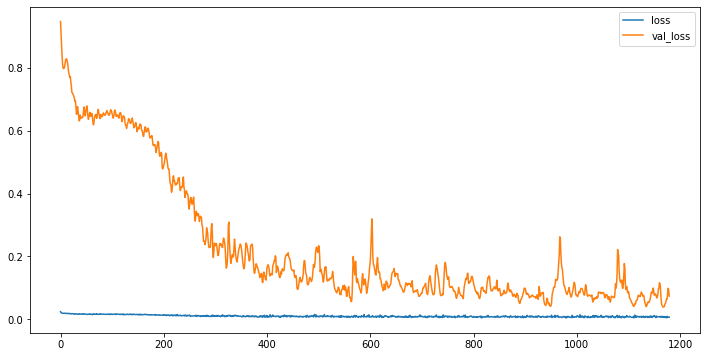

In [13]:
%%time

X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
print(X_train.shape, y_train.shape)

model, history = trainLSTM(X_train, y_train)
print('loss: {:.5}'.format(history.history['loss'][-1]))
print('val_loss: {:.5}'.format(history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE: 1.631e+04


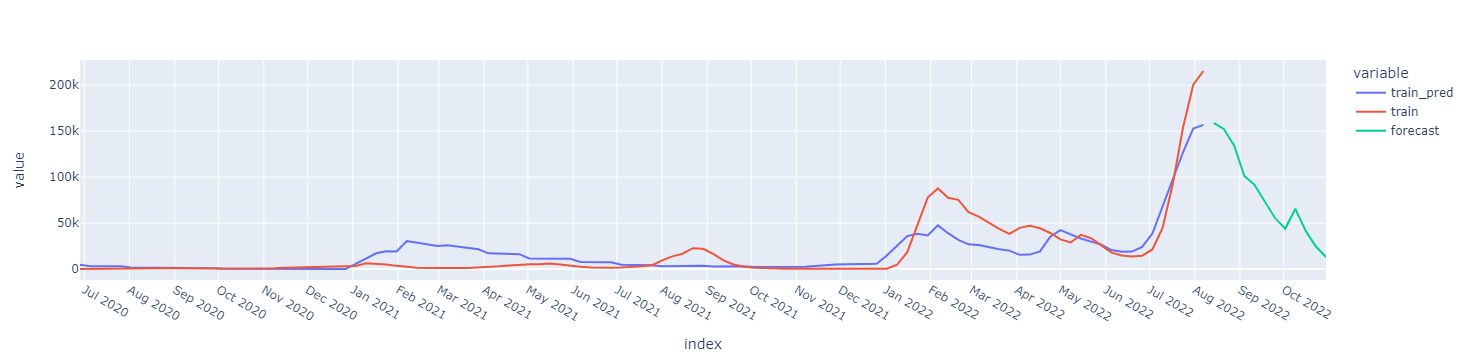

In [14]:
X_train = X[X.index <= last_date]
y_train = y[y.index <= last_date]
y_train_index = y_train.index

y_pred = model.predict(X_train)
y_pred = sc.inverse_transform(y_pred).ravel()
y_pred = pd.Series(y_pred, index=y_train_index, name='train_pred')
y_train = sc.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_train = pd.Series(y_train, index=y_train_index, name='train')

rmse = np.sqrt( mean_squared_error(y_train, y_pred) )
print('RMSE: {:.5}'.format(rmse))

X_forecast = X[X.index > last_date]
y_forecast = y[y.index > last_date]
y_forecast_index = y_forecast.index

y_forecast = model.predict(X_forecast)
y_forecast = sc.inverse_transform(y_forecast).ravel()
y_forecast = pd.Series(y_forecast, index=y_forecast_index, name='forecast')

# plt.plot(y_pred, label='train pred')
# plt.plot(y_train, label='test')
# plt.plot(y_forecast, label='forecast')
# plt.legend()

fig = px.line(pd.concat([y_pred, y_train, y_forecast], axis=1))
fig.update_layout({
    'xaxis': {
        'dtick': 'M1'
    }
})
fig.show()